# Final Notebook: Poisoning, Data Selection, and Pruning
**Comparing:** Full data, Random subset, EL2N, Forgettability, and CRAIG-approx selection methods.

This notebook runs prototype experiments on CIFAR-10 with label-flip and backdoor poisons, computes
attack success rate (ASR), poison retention, clean accuracy, and shows comparison plots.

**Usage:** Set `PROTOTYPE = True` for quick runs on Colab/GPU. For final experiments, set `PROTOTYPE=False` and
increase epochs and repetitions.


In [ ]:
# -------------------------
# Setup: installs, imports, reproducibility
# -------------------------
PROTOTYPE = True  # set False for full experiments

import random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

Device: mps


In [ ]:
# -------------------------
# Data transforms & load CIFAR-10
# -------------------------
if PROTOTYPE:
    train_epochs = 8
    batch_size = 128
    subset_frac = 0.25
    el2n_epochs = 2
    forget_epochs = 3
    num_workers = 0
else:
    train_epochs = 50
    batch_size = 128
    subset_frac = 0.5
    el2n_epochs = 5
    forget_epochs = 10
   
data_root = './data'
num_workers = 0

Files already downloaded and verified
Files already downloaded and verified
Loaded CIFAR-10: train size 50000 test size 10000


In [ ]:
from dataset import data_loaders
train_set, test_set, train_loader_full, test_loader = data_loaders(data_root, batch_size, num_workers)

In [ ]:
from dataset import new_backdoor_dataset
from train_utils import *
from utils import *
from model import get_model
from el2n import compute_el2n_scores
from forgetting import compute_forgetting_scores
from craig import select_subset_craig
from prune import iterative_magnitude_prune_and_retrain
from torch.utils.data import DataLoader

# -------------------------
# Orchestrate all methods and evaluate
# -------------------------
def run_all_methods(poison_type='backdoor', poison_frac=0.02, subset_frac=0.25, selection_methods=None, device='cuda'):
    if selection_methods is None:
        selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']
    
    results = {}
    
    # Prepare poisoned dataset
    ds_poisoned = new_backdoor_dataset(data_root, poison_frac)

    poisoned_set = ds_poisoned.poisoned_idx
    n = len(ds_poisoned)
    k = int(n * subset_frac)
    print(f'Running poison_type={poison_type}, poison_frac={poison_frac}, subset size {k} (of {n})')
    
    for method in selection_methods:
        print(f'\n---- Selection method: {method} ----')
        
        if method == 'full':
            indices = list(range(n))
        elif method == 'random':
            indices = sample_random_indices(ds_poisoned, k, seed=seed)
        elif method == 'el2n':
            scores = compute_el2n_scores(lambda: get_model(device=device), ds_poisoned, epochs=el2n_epochs, device=device, num_workers=num_workers)
            # Select examples with HIGHEST EL2N scores (hardest examples)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'forget':
            scores = compute_forgetting_scores(lambda: get_model(device=device), ds_poisoned, epochs=forget_epochs, device=device, num_workers=num_workers)
            # Select examples with HIGHEST forgetting scores (unstable examples)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'craig':
            indices = select_subset_craig(lambda: get_model(device=device), ds_poisoned, subset_size=k, device=device, num_workers=num_workers)
        
        subset = subset_from_indices(ds_poisoned, indices)
        
        # Train model on subset
        model = get_model(device=device)
        opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[30, 40], gamma=0.1)
        crit = nn.CrossEntropyLoss()
        
        for e in range(train_epochs):
            train_one_epoch(model, DataLoader(subset, batch_size=batch_size, shuffle=True), opt, crit, 
                           desc=f'{method}-Train-E{e}', device=device)
            scheduler.step()
        
        # Evaluate dense model
        loss, acc = evaluate(model, test_loader, device=device)
        
        if poison_type == 'backdoor':
            asr = compute_backdoor_asr(model, test_loader, trigger_patch_size=6, target_label=0, device=device)
        else:
            asr = compute_labelflip_asr(model, test_loader, source_label=0, target_label=1, device=device)
        
        kept, total_poison, retention = compute_poison_retention(poisoned_set, indices)
        
        print(f'Dense model - Clean accuracy: {acc:.4f}, ASR: {asr:.4f}')
        print(f'Poison retention: {kept}/{total_poison} ({retention:.4f})')
        
        # PRUNING SECTION - RESTORED
        print("Applying iterative magnitude pruning...")
        pruned_model, mask = iterative_magnitude_prune_and_retrain(
            lambda: get_model(device=device),
            subset,
            test_loader,
            fraction_to_prune=0.3,
            iterations=2,
            rewind_epoch=1,
            epochs_per_cycle=10,
            device=device
        )
        
        # Evaluate pruned model
        ploss, pacc = evaluate(pruned_model, test_loader, device=device)
        if poison_type == 'backdoor':
            pasr = compute_backdoor_asr(pruned_model, test_loader, trigger_patch_size=6, target_label=0, device=device)
        else:
            pasr = compute_labelflip_asr(pruned_model, test_loader, source_label=0, target_label=1, device=device)
        
        print(f'Pruned model - Clean accuracy: {pacc:.4f}, ASR: {pasr:.4f}')
        
        results[method] = {
            'subset_size': len(indices),
            'clean_acc': acc,
            'asr': asr,
            'poison_kept': kept,
            'poison_total': total_poison,
            'poison_retention': retention,
            'pruned_acc': pacc,
            'pruned_asr': pasr
        }
    
    return results

In [13]:
selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']

In [ ]:
# Backdoor experiment
res_backdoor = run_all_methods(poison_type='backdoor', poison_frac=0.02, subset_frac=subset_frac, selection_methods=selection_methods, device=device)
print('\nBackdoor results:'); print(res_backdoor)

In [ ]:
from results import *

In [ ]:
save_results_csv(res_backdoor, fname='backdoor_results_prototype.csv')

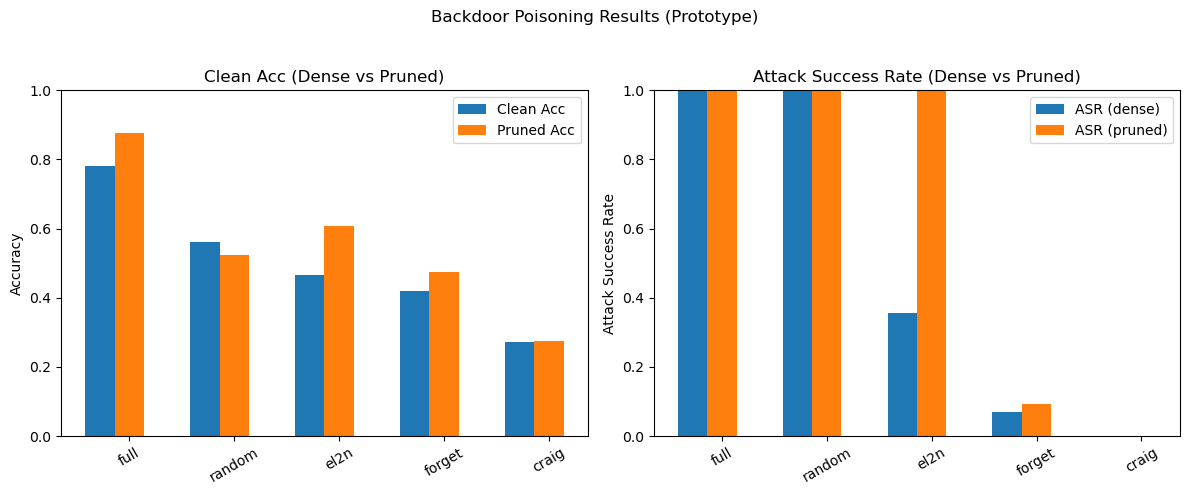

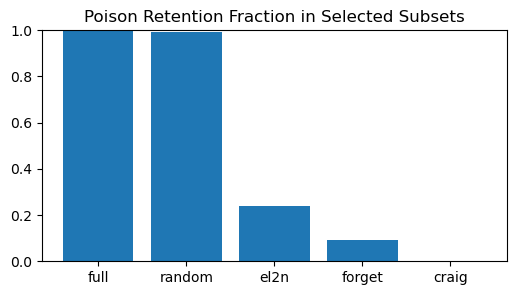

In [15]:
plot_results(res_backdoor, title='Backdoor Poisoning Results (Prototype)')